In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('palm.csv')
df_w = pd.read_csv('palm_watering.csv')

In [27]:
# Create "last watered column, from the palm_watering csv"
df['last_watered'] = df['time_stamp'].apply(lambda x: df_w[df_w['time_stamp'] < x]['time_stamp'].iloc[-1] if len(df_w[df_w['time_stamp'] < x]) > 0 else None)

In [28]:
# for each 'last_watered' group, remove all the entries before the max soil_moisture_1 and after the min soil_moisture_1
# then, create a new column 'peak_moisture' with the max soil_moisture_1, and 'time_peak' with the time of the max soil_moisture_1
# and 'moisture_before_watering' with the min soil_moisture_1 before the max soil_moisture_1
last_min_moisture = None

filtered_groups = []
for name, group in df.groupby('last_watered'):
    max_moisture_index = group['soil_moisture_1'].idxmax()
    min_moisture_index = group['soil_moisture_1'].idxmin()

    print((max_moisture_index, min_moisture_index))

    if max_moisture_index > min_moisture_index:
        print(f"Skipping group {name} because max moisture comes after min moisture")
        continue 

    filtered_group = group.loc[max_moisture_index:min_moisture_index]

    filtered_group['peak_moisture'] = group['soil_moisture_1'].max()
    filtered_group['time_peak'] = group[group['soil_moisture_1'] == group['soil_moisture_1'].max()]['time_stamp'].iloc[0]

    if last_min_moisture is not None:
        filtered_group['moisture_before_watering'] = last_min_moisture
    else:
        filtered_group['moisture_before_watering'] = df.loc[:max_moisture_index]['soil_moisture_1'].min()

    last_min_moisture = group.loc[min_moisture_index]['soil_moisture_1']

    filtered_groups.append(filtered_group)


df_filtered = pd.concat(filtered_groups)


(np.int64(20), np.int64(2871))
(np.int64(2880), np.int64(6248))
(np.int64(6253), np.int64(7204))
(np.int64(7208), np.int64(11985))
(np.int64(12091), np.int64(15360))


C:\Users\coolj\AppData\Local\Temp\ipykernel_24104\2772685702.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_group['peak_moisture'] = group['soil_moisture_1'].max()
C:\Users\coolj\AppData\Local\Temp\ipykernel_24104\2772685702.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_group['time_peak'] = group[group['soil_moisture_1'] == group['soil_moisture_1'].max()]['time_stamp'].iloc[0]
C:\Users\coolj\AppData\Local\Temp\ipykernel_24104\2772685702.py:25: SettingWithCopyWarning: 
A value 

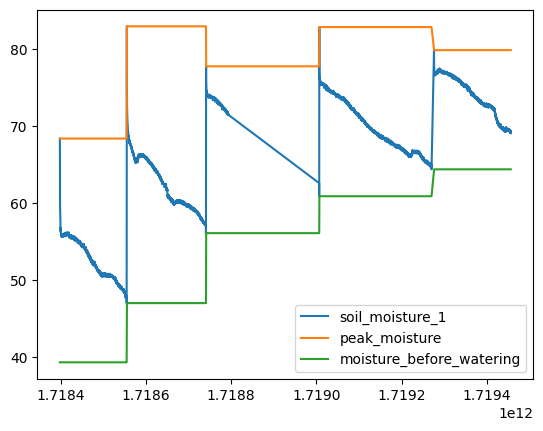

In [29]:
# plot the new data
plt.plot(df_filtered['time_stamp'], df_filtered['soil_moisture_1'], label='soil_moisture_1')
plt.plot(df_filtered['time_stamp'], df_filtered['peak_moisture'], label='peak_moisture')
plt.plot(df_filtered['time_stamp'], df_filtered['moisture_before_watering'], label='moisture_before_watering')
plt.legend()

In [30]:
df_filtered.to_csv('palm_features.csv', index=False)

In [31]:
len(df_filtered)

15221

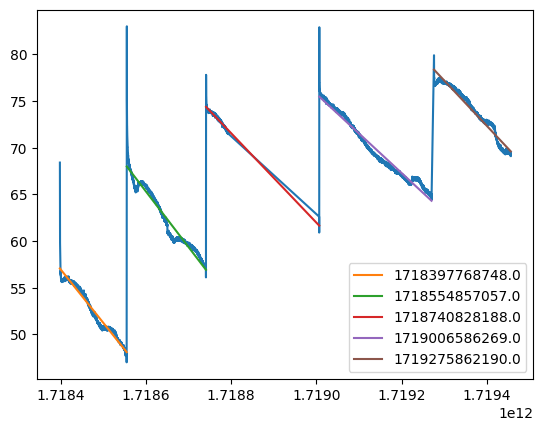

(np.float64(0.9549437783280039), np.float64(0.012702273279028151))

In [36]:

from sklearn.linear_model import LinearRegression

plt.plot(df_filtered["time_stamp"], df_filtered["soil_moisture_1"])
for name, group in df_filtered.groupby('last_watered'):
    X = group['time_stamp'].values.reshape(-1, 1)
    y = group['soil_moisture_1'].values

    reg = LinearRegression().fit(X, y)
    plt.plot(group['time_stamp'], reg.predict(X), label=name)

plt.legend()
plt.show()

r2s = []

for name, group in df_filtered.groupby('last_watered'):
    X = group['time_stamp'].values.reshape(-1, 1)
    y = group['soil_moisture_1'].values

    reg = LinearRegression().fit(X, y)
    r2s.append((name, reg.score(X, y)))

r2s = np.array(r2s)

r2s[:, 1].mean(), r2s[:, 1].std()
